# `opinf.pre`

```{eval-rst}
.. automodule:: opinf.pre
```

## Preprocessing Data

Raw dynamical systems data often need to be lightly preprocessed before use in Operator Inference.
The tools in this module enable centering/shifting and scaling/nondimensionalization of snapshot data after lifting (when applicable) and prior to dimensionality reduction.

```{eval-rst}
.. currentmodule:: opinf.pre

.. autosummary::
    :toctree: _autosummaries
    :nosignatures:

    shift
    scale
    SnapshotTransformer
    SnapshotTransformerMulti
    TransformerTemplate
```

:::{admonition} Notation
:class: note

On this page, we use $\s \in \RR^n$ to denote the unprocessed state variable for which we have $k$ snapshots $\s_j\in\RR^n$, $j=0, \ldots, k-1$, and use $\q\in\RR^n$ to denote the processed state variable to be used in dimensionality reduction.
That is, the tools demonstrated here define a mapping $\mathcal{T}:\RR^n\to\RR^n$ with $\q = \mathcal{T}(\s)$.
:::

::::{admonition} Example Data
:class: note

The examples on this page use data from the combustion problem described in {cite}`swischuk2020combustion`.
The data consists of nine variables recorded at 100 points in time.

:::{dropdown} State Variables

- Pressure $p$
- $x$-velocity $v_{x}$
- $y$-velocity $v_{y}$
- Temperature $T$
- Specific volume $\xi$
- Chemical species molar concentrations for CH$_{4}$, O$_{2}$, CO$_{2}$, and H$_{2}$O.

The dimension of the spatial discretization in the full example in {cite}`swischuk2020combustion` is $38{,}523$ per variable, so $n = 9 \times 38{,}523 = 346{,}707$.
Here we have downsampled the state dimension to $535$ for each variable for demonstration purposes, i.e., $n = 9 \times 535 = 4{,}815$.
:::

You can [download the data here](https://github.com/Willcox-Research-Group/rom-operator-inference-Python3/raw/data/data_scaling_example.npy) to repeat the experiments.
::::

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

import opinf

opinf.utils.mpl_config()

In [2]:
# Load the example snapshot data.
snapshots = np.load("data_scaling_example.npy")

snapshots.shape

(4815, 100)

## Shifting / Centering

A common first preprocessing step is to shift the training snapshots by some reference snapshot $\bar{\mathbf{s}}$, i.e.,

$$
    \mathbf{q}(t) = \mathbf{s}(t) - \bar{\mathbf{s}}.
$$

For example, the reference snapshot could be chosen to be the average of the training snapshots:

$$
    \bar{\mathbf{s}}
    := \frac{1}{k}\sum_{j=0}^{k-1}\mathbf{s}_{j}.
$$

In this case, the transformed snapshots $\mathbf{q}_{j} = \mathbf{s}_{j} - \bar{\mathbf{s}}$ are centered around $\mathbf{0}$.
This type of transformation can be accomplished using a {class}`SnapshotTransformer` or the {func}`shift()` function.

In [14]:
# Extract the pressure variable from the snapshot data.
pressure = np.split(snapshots, 9, axis=0)[0]

# Initialize a SnapshotTransformer for centering the pressure variable.
pressure_transformer = opinf.pre.SnapshotTransformer(
    centering=True,
    verbose=True,
)

# Shift the pressure snapshots by the average pressure snapshot.
pressure_shifted = pressure_transformer.fit_transform(pressure)

Learned mean centering Q -> Q'
    |     min    |    mean    |     max    |    std
----|------------|------------|------------|------------
Q   |  9.141e+05 |  1.143e+06 |  1.432e+06 |  6.470e+04
Q'  | -2.332e+05 | -3.388e-12 |  2.743e+05 |  6.461e+04



In [8]:
# Average pressure value.
np.mean(pressure)

1143160.4356617983

In [9]:
# Average shifted pressure value.
np.mean(pressure_shifted)

-3.3880122632623834e-12

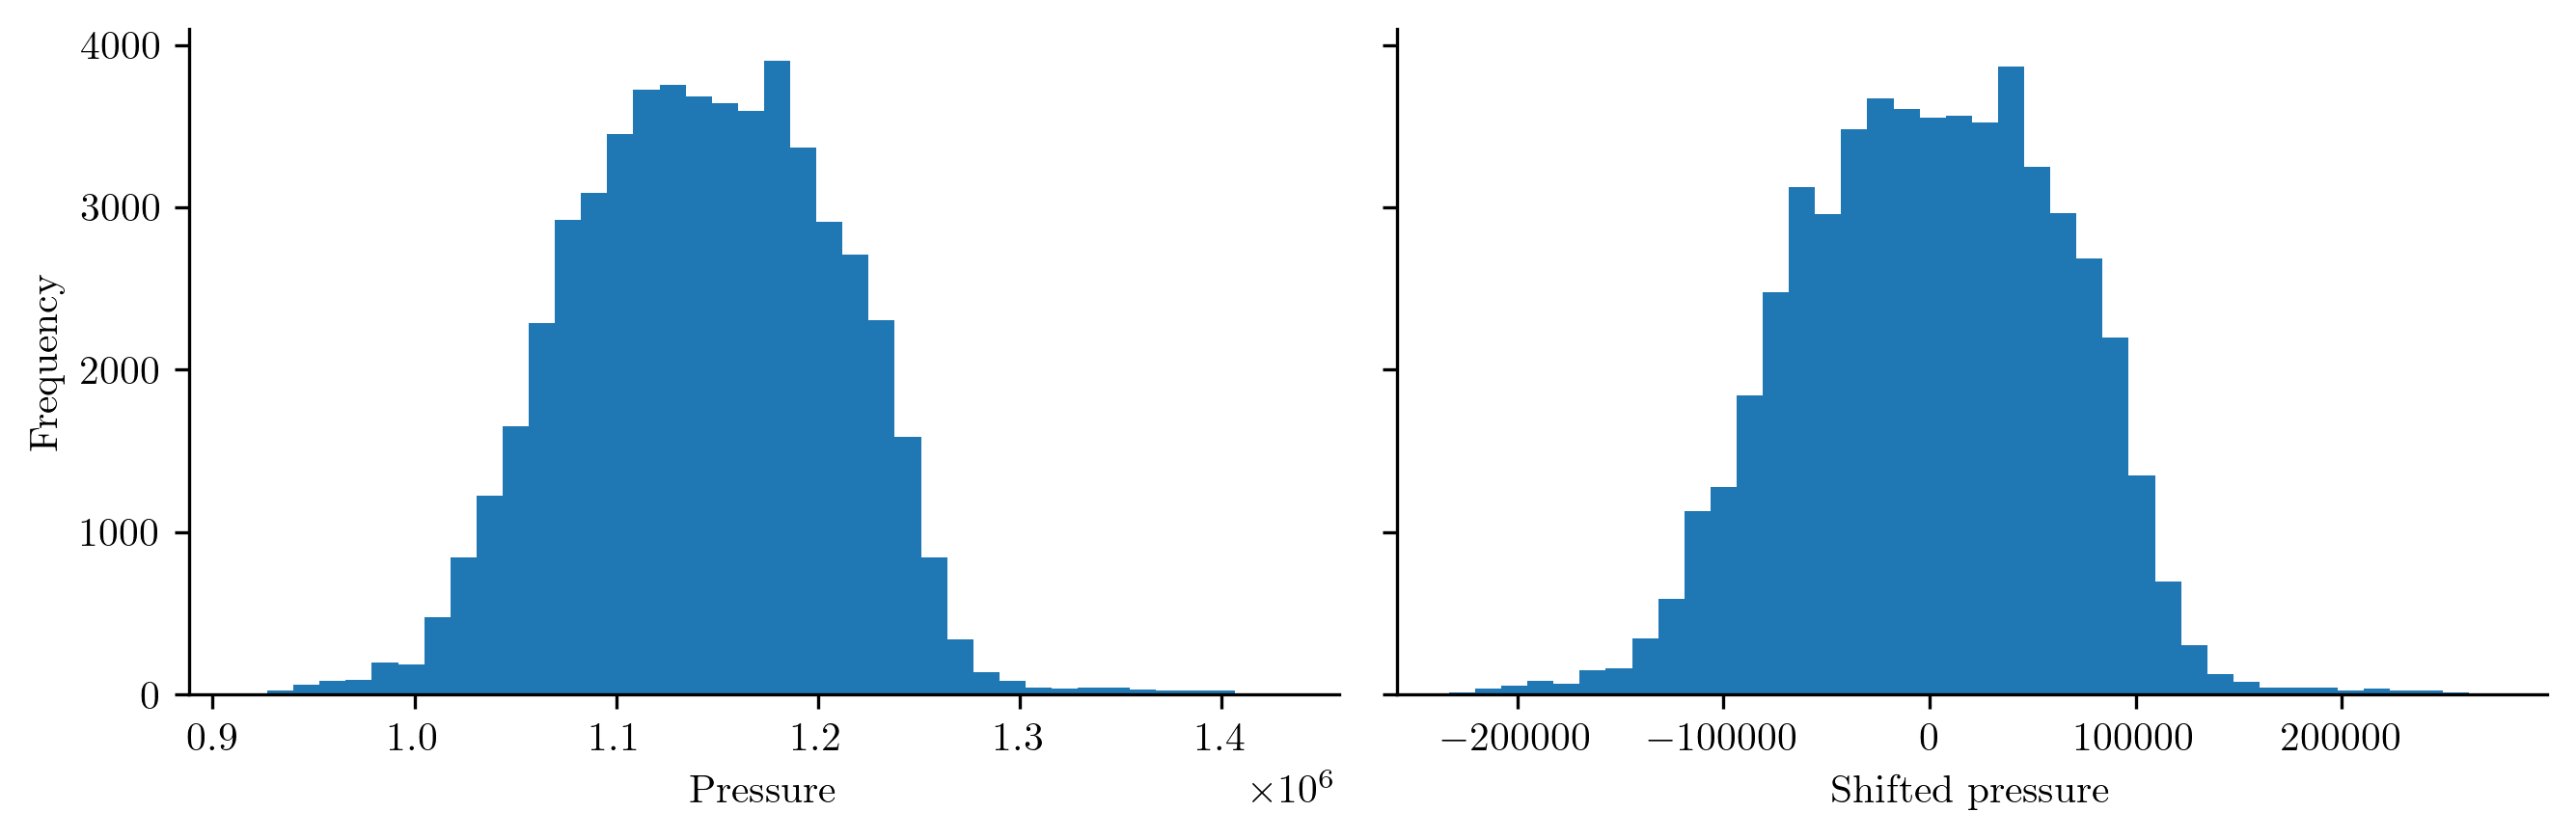

In [10]:
# Plot the distribution of the entries of the raw and processed states.
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].hist(pressure.flatten(), bins=40)
axes[1].hist(pressure_shifted.flatten(), bins=40)
axes[0].set_ylabel("Frequency")
axes[0].set_xlabel("Pressure")
axes[1].set_xlabel("Shifted pressure")
fig.tight_layout()
plt.show()

## Scaling (Non-dimensionalization)

Many engineering problems feature multiple variables with ranges across different scales.
For such cases, it is often beneficial to scale the variables to similar ranges so that one variable does not overwhelm the other in the operator learning.

A simple scaling is given by

$$
    \q = \frac{1}{\alpha}\s),
$$

where $\alpha$ is chosen by examining the range of the training data.
For example, after centering the data, a scaling to $[-1, 1]$ is given by

$$
    \q
    = \frac{1}{\alpha}\big(\s - \bar{\s}\big),
    \qquad
    \alpha = \max_{i,j}|\tilde{s}_{ij}|
$$

where $\tilde{s}_{ij}$ is the $i$th entry of $\s_j - \bar{\s}$.
The `scaling` argument of the {class}`SnapshotTransformer` determines the type of scaling transformation; see also {func}`scale()`.

In [11]:
# Extract the H2O molar concentration.
water = np.split(snapshots, 9, axis=0)[-1]

# Compare the scales of the variables.
print(f"Pressure range (raw):\t\t[{pressure.min():.2e}, {pressure.max():.2e}]")
print(
    f"Pressure range (shifted):\t[{pressure_shifted.min():.2e}, {pressure_shifted.max():.2e}]"
)
print(f"Water range:\t\t\t[{water.min():.2e}, {water.max():.2e}]")

Pressure range (raw):		[9.14e+05, 1.43e+06]
Pressure range (shifted):	[-2.33e+05, 2.74e+05]
Water range:			[0.00e+00, 7.70e-03]


In [12]:
# Apply a min-max scaling to [0, .01] on the shifted pressure snapshots.
pressure_scaled, pscale1, pscale2 = opinf.pre.scale(
    pressure_shifted,
    (0, 1e-2),
)

In [13]:
# Compare the scales of the variables.
print(f"Pressure range (raw):\t\t[{pressure.min():.2e}, {pressure.max():.2e}]")
print(
    f"Pressure range (shifted):\t[{pressure_shifted.min():.2e}, {pressure_shifted.max():.2e}]"
)
print(
    f"Pressure range (scaled):\t[{pressure_scaled.min():.2e}, {pressure_scaled.max():.2e}]"
)
print(f"Water range:\t\t\t[{water.min():.2e}, {water.max():.2e}]")

Pressure range (raw):		[9.14e+05, 1.43e+06]
Pressure range (shifted):	[-2.33e+05, 2.74e+05]
Pressure range (scaled):	[0.00e+00, 1.00e-02]
Water range:			[0.00e+00, 7.70e-03]


## Multivariable Data

For systems where the full state consists of several variables (pressure, velocity, temperature, etc.), it may not be appropriate to apply the same scaling to each variable.
The {class}`SnapshotTransformerMulti` class handles multivariable data by constructing a separate {class}`SnapshotTransformer` instance for each variable.
The constructor accepts the number of state variables and the same parameters as the constructor of {class}`SnapshotTransformer`.

The following code constructs the following transformation for the nine state variables.
- Pressure: center, then scale to $[-1, 1]$.
- $x$-velocity: Scale to $[-1, 1]$.
- $y$-velocity: Scale to $[-1, 1]$.
- Temperature: center, then scale to $[-1, 1]$.
- Specific volume: scale to $[0, 1]$.
- Chemical species: scale to $[0, 1]$.

In [ ]:
# Learn the variable transformation used in the paper.
combustion_transformer = opinf.pre.SnapshotTransformerMulti(
    9,
    center=(True, False, False, True, False, False, False, False, False),
    scaling=(
        "maxabs",
        "maxabs",
        "maxabs",
        "maxabs",
        "minmax",
        "minmax",
        "minmax",
        "minmax",
        "minmax",
    ),
    variable_names=["p", "vx", "vy", "T", "xi", "CH4", "O2", "CO2", "H2O"],
    verbose=True,
)

snapshots_preprocessed = combustion_transformer.fit_transform(snapshots)

## Custom Transformers

New transformers can be defined by inheriting from the {class}`TransformerTemplate`.

### Inheritance Template

In [ ]:
import opinf


class CustomTransformer(opinf.pre.TransformerTemplate):
    pass